In [2]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import regex as re
import os
import json
#pd.set_option('display.max_rows', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the specific folder
os.chdir('/content/drive/MyDrive/AMLO_files/')

# Verify the current directory
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/AMLO_files


# Collecting transcripts from WaybackMachine

In [ ]:
#!pip install waybackpy


In [ ]:
from waybackpy import WaybackMachineCDXServerAPI
user_agent = "my new app's user agent"

In [ ]:
#df = pd.read_csv('conference_links_full.csv').sort_values('dates2')
df = pd.read_csv('/content/drive/MyDrive/AMLO_files/conference_links_full.csv').sort_values('dates2')

df.head()

,date,url,title,dates2,month,year
23,"enero 10, 2019",https://lopezobrador.org.mx/2019/01/10/version...,Versión estenográfica de la conferencia de pre...,1/10/2019,1,2019
271,"enero 10, 2020",https://lopezobrador.org.mx/2020/01/10/version...,Versión estenográfica de la conferencia de pre...,1/10/2020,1,2020
758,"enero 10, 2022",https://lopezobrador.org.mx/2022/01/10/version...,Versión estenográfica de la conferencia de pre...,1/10/2022,1,2022
1245,"enero 10, 2024",https://lopezobrador.org.mx/2024/01/10/version...,Versión estenográfica de la conferencia de pre...,1/10/2024,1,2024
24,"enero 11, 2019",https://lopezobrador.org.mx/2019/01/11/version...,Versión estenográfica de la conferencia de pre...,1/11/2019,1,2019


In [ ]:
#files = os.listdir('texts')
files = os.listdir('/content/drive/MyDrive/AMLO_files/texts')

files = [el.split('.')[0] for el in files if el.endswith('html')]


In [ ]:
set(files) - set(df.dates2)

In [ ]:

df = df[~df.dates2.isin(files)]

df.shape

(1425, 6)

In [ ]:
failed_dates = []

for (i, row) in tqdm(df.iterrows()):

    try:
        date = row['dates2']

        cdx_api = WaybackMachineCDXServerAPI(row['url'], user_agent)

        try:
            newest = cdx_api.newest()

            page = requests.get(newest.archive_url)

            with open(f'texts/{date}.html', 'wb+') as f:
                f.write(page.content)

        except:

            oldest = cdx_api.oldest()

            page = requests.get(oldest.archive_url)

            with open(f'texts/{date}.old.html', 'wb+') as f:
                f.write(page.content)

    except:

        failed_dates.append(date)


print(failed_dates)


# Some ugly functions that we need for cleaning

In [ ]:
def clean_html_tags(html_string):

    # Iterate through all the tags in the parsed HTML
    for tag in html_string.find_all(True):  # True finds all tags
        tag.attrs = {}  # Remove all attributes for the tag

    # Convert the cleaned HTML back to a string
    return str(html_string)



def is_uppercase_or_digit_or_punctuation(s):
    # Regular expression to check for only uppercase letters, numbers, or punctuation
    pattern = r'^[A-Z0-9\p{P}\s]+$'

    # Return True if it matches the pattern, else False
    return bool(re.match(pattern, s))


def is_spanish_question(s: str) -> bool:
    # Strip any leading or trailing spaces
    s = s.strip()

    # Check if the string starts with '¿' and ends with '?'
    if s.startswith('¿') and s.endswith('?'):
        return True
    else:
        return False


def clean_paragraph(x):

    x = x.replace('<b>', '').replace('</b>', '').replace('</p>', '').replace('<p>','').replace('\n', ' ').replace('<span>', '').replace('</span>', '')

    return x

def find_true_index(logical_list):
    try:
        return logical_list.index(True)
    except ValueError:
        return 0




def extract_exchange(question, tag):

    # Initialize an empty list to hold the fragments
    fragments = []

    current_speaker = None
    current_fragment = []
    i = 0


    if tag in ['b', 'nothing']:

        question = BeautifulSoup(question, 'html.parser')


        # Find all <p> tags
        paragraphs = question.find_all('p')


        for p in paragraphs:
            # Check if the paragraph contains a speaker identifier
            bold_tag = p.find('b')

            if bold_tag and ':' in p.text:
                # If there's an ongoing fragment, append it to fragments
                if current_fragment:
                    fragment_html = ''.join(str(tag) for tag in current_fragment)
                    fragments.append({
                        'speaker': current_speaker,
                        'html': fragment_html,
                        'order':i
                    })
                    i += 1
                    current_fragment = []

                # Extract speaker's name and initialize a new fragment
                current_speaker = bold_tag.text.strip(':').strip()
                bold_tag.extract()


            # Append the current <p> tag to the current fragment as HTML
            current_fragment.append(p)

        # Append the last fragment if it exists
        if current_fragment:
            fragment_html = ''.join(str(tag) for tag in current_fragment)
            fragments.append({
                'speaker': current_speaker,
                'html': fragment_html
            })



    elif tag in ['plain']:

        paragraphs = re.split(r'(<p>|<br/>)', str(question))


        for p in paragraphs:
            # Check if the paragraph contains a speaker identifier

            p1 = p

            if is_uppercase_or_digit_or_punctuation(p1[:7]) and ':' in p1:
                # If there's an ongoing fragment, append it to fragments
                if current_fragment:
                    fragment_html = ''.join(current_fragment)
                    fragments.append({
                        'speaker': current_speaker,
                        'html': fragment_html,
                        'order': i
                    })
                    current_fragment = []
                    i += 1
                # Extract speaker's name and initialize a new fragment
                current_speaker = p1.split(':')[0].strip()
                p1 = ''.join(p1.split(':')[1:])


            # Append the current <p> tag to the current fragment as HTML
            current_fragment.append(p1)

        # Append the last fragment if it exists
        if current_fragment:
            fragment_html = ''.join(current_fragment)
            fragments.append({
                'speaker': current_speaker,
                'html': fragment_html
            })


    return fragments

# Splitting into questions

In [ ]:
files = os.listdir('/content/drive/MyDrive/AMLO_files/texts')

files = [el for el in files if el.endswith('html')]

In [ ]:
files_summary = dict()

bad = []

pattern_strong = r'<strong>\s*PREGUNTA\s*:?\s*[¿?,]?\s*</strong>'
pattern_b = r'<b>\s*PREGUNTA\s*:?\s*[¿?,]?\s*</b>'
pattern_plain = r'\s*PREGUNTA\s*:?'

pattern_bi = r'<b>\s*INTERLOCUTORA?\s*:?\s*[¿?,]?\s*</b>'
pattern_plaini = r'\s*INTERLOCUTORA?\s*:?'


pregunta_tag = {'b':"<p><b>PREGUNTA</b>:", 'plain':"<p>PREGUNTA:"}


results = {}

for date in tqdm(files):

    try:

        # Reading
        #with open(f'texts/{date}', 'r', errors="ignore") as fp:
        #    soup = BeautifulSoup(fp, 'html.parser')
        with open(f'/content/drive/MyDrive/AMLO_files/texts/{date}', 'r', errors="ignore") as fp:
            soup = BeautifulSoup(fp, 'html.parser')

        # main part
        transcript = soup.findAll('div', class_='entry-content')[0]


        # remove tag attributes
        # e.g. <p style='blalbla'> ---> <p>
        transcript = clean_html_tags(transcript)

        # Convert the transcript's HTML content to a string
        transcript_html_full = str(transcript)

        # Standardize bold tags
        transcript_html_full = transcript_html_full.replace('<strong>', '<b>')
        transcript_html_full = transcript_html_full.replace('</strong>', '</b>')

        # Standardize italics tags
        transcript_html_full = transcript_html_full.replace('<em>', '<i>')
        transcript_html_full = transcript_html_full.replace('</em>', '</i>')

        # Remove stupid non-breaking spaces
        transcript_html_full = transcript_html_full.replace(u'\xa0', u' ')

        #remove some other useless tags
        transcript_html_full = transcript_html_full.replace('<meta/>', '').replace('<meta>', '').replace('</font>', '').replace('<font>', '').replace('<span>', '').replace('</span>', '')

        # Split the HTML string

        # PREGUNTA patterns
        fragments_html_b = re.split(pattern_b, transcript_html_full)
        fragments_html_p = re.split(pattern_plain, transcript_html_full)

        # interlocutor patterns (need to detect irregularities in bold/plain speaker identifiers
        fragments_html_bi = re.split(pattern_bi, transcript_html_full)
        fragments_html_pi = re.split(pattern_plaini, transcript_html_full)


        # number of elemennts after splitting
        n_b = len(fragments_html_b) - 1
        n_p = len(fragments_html_p) - 1 - n_b

        n_bi = len(fragments_html_bi) - 1
        n_pi = len(fragments_html_pi) - 1 - n_bi


        # if numbers are the same, it is bold type
        # if there is variation, then we probably have some variation in bold/plain which means that we will treat it as plain

        if ((n_b > 0) and (n_p > 0)) or ((n_bi > 0) and (n_pi > 0)):
            question_tag = 'plain'

        elif ((n_b > 0) and (n_p == 0)):
            question_tag = 'b'

        elif ((n_b == 0) and (n_p > 0)):
            question_tag = 'plain'

        else:
            question_tag = 'nothing'


        pattern = r'(<p>|<br/>)' # r'<\/?p\b[^>]*>|<br\/?>'


        # Clean first element
        #
        if question_tag == 'b':

            paragraphs = re.split(r'(<p>|<br/>)', fragments_html_b[0])
            p_clean = [clean_paragraph(p) for p in paragraphs]
            i_split = find_true_index([is_uppercase_or_digit_or_punctuation(p[:7]) and ':' in p for p in p_clean])


            new_fragment_container = [
                ''.join(paragraphs[0:i_split]),  ''.join(['<p>' + paragraphs[i_split]] + paragraphs[(i_split+1):])
            ] + [
                "<p><b>PREGUNTA</b>:" + fragment for fragment in fragments_html_b[1:2]
                ]

            fragments_html_p = fragments_html_b

        elif question_tag == 'plain':

            paragraphs = re.split(r'(<p>|<br/>)', fragments_html_p[0])
            p_clean = [clean_paragraph(p) for p in paragraphs]
            i_split = find_true_index([is_uppercase_or_digit_or_punctuation(p[:7]) and ':' in p for p in p_clean])

            new_fragment_container = [
                ''.join(paragraphs[0:i_split]),  ''.join(paragraphs[i_split:])
            ] + [
                 "<p>PREGUNTA:" + fragment for fragment in fragments_html_p[1:2]
                ]

        else:

            paragraphs = re.split(r'(<p>|<br/>)', fragments_html_p[0])
            p_clean = [clean_paragraph(p) for p in paragraphs]
            i_split = find_true_index([is_uppercase_or_digit_or_punctuation(p[:7]) and ':' in p for p in p_clean])

            new_fragment_container = [
                ''.join(paragraphs[0:i_split]),  ''.join(['<p>' + paragraphs[i_split]] + paragraphs[(i_split+1):])
            ]





        # loop other questions to determinee if new "PREGUNTA" is indeed new or a clarification from presumably the same speaker

        for r in range(2, len(fragments_html_p)):



            paragraphs = re.split(pattern, #r'(<p>|<br/>)',
                                  fragments_html_p[r])

            #print(paragraphs)
            current_fragment = []

            fragment_html = ''


            for p in paragraphs:
                    # Check if the paragraph contains a speaker identifier

                p1 = p.replace('<b>', '').replace('</b>', '').replace('<br/>','').replace('</p>', '').replace('<p>','').replace('\n', ' ')

                if is_uppercase_or_digit_or_punctuation(p1[:7]) and ':' in p1:
                        # If there's an ongoing fragment, append it to fragments
                    if current_fragment:
                        fragment_html = ''.join(current_fragment)

                        break


                current_fragment.append(p)


            i_in_text = ('<i>' in fragment_html) or ('</i>' in fragment_html) #check if italics in text

            fragment_html = fragment_html.replace('<b>', '').replace('</b>', '').replace('<br/>','').replace('</p>', '').replace('<p>','').replace('\n', ' ').replace('<i>', '').replace('</i>', '').strip(' :><')

            #qus.append([fragment_html, len(fragment_html), i_in_text, date])


            if (is_spanish_question(fragment_html) or  len(fragment_html) < 120 ) and (i_in_text == False):

                new_fragment_container[-1] = new_fragment_container[-1] + pregunta_tag[question_tag] + fragments_html_p[r]

            else:
                new_fragment_container.append(pregunta_tag[question_tag] + fragments_html_p[r])





        # for a summary table
        files_summary[date] = {'question_tag':question_tag,
                               'n_b':n_b,
                               'n_p':n_p,
                               'n_bi':n_bi,
                               'n_pi':n_pi,
                                'n_q':len(new_fragment_container)}

        # container with splitted questions
        results[date] = {'question_tag': question_tag,
                         'text': new_fragment_container}


    except:

        bad.append(date)

print(bad)

100%|██████████| 1421/1421 [02:31<00:00,  9.38it/s]

[]


In [ ]:
data_summary = pd.DataFrame.from_dict(files_summary, orient='index')

In [ ]:
data_summary

,question_tag,n_b,n_p,n_bi,n_pi,n_q
2024-02-13.html,b,5,0,25,0,7
2023-03-27.old.html,b,14,0,13,0,7
2022-05-24.old.html,b,3,0,17,0,5
2023-04-21.html,b,3,0,13,0,4
2023-07-19.old.html,b,5,0,7,0,5
...,...,...,...,...,...,...
2023-06-19.html,plain,0,6,0,14,6
2023-06-09.html,b,13,0,24,0,8
2024-01-15.html,b,13,0,24,0,4
2022-04-28.old.html,b,3,0,7,0,5


In [ ]:
data_summary['n_q']  = data_summary.n_q - 2

In [ ]:
data_summary.to_csv('/content/drive/MyDrive/AMLO_files/questions_summary.csv', index=True)

In [4]:
data_summary = pd.read_csv('/content/drive/MyDrive/AMLO_files/questions_summary.csv')

In [7]:
data_summary.question_tag.value_counts()

,count
question_tag,
b,1273
plain,139
nothing,9


<Axes: >

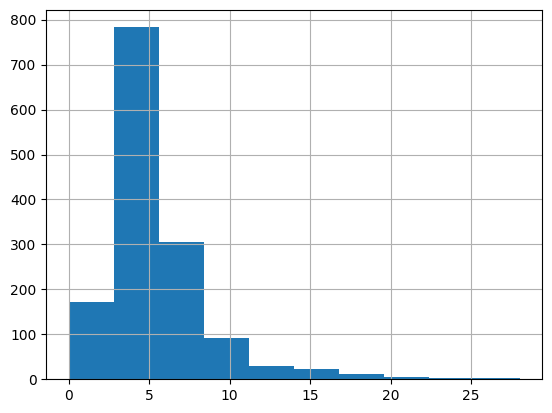

In [5]:
data_summary.n_q.hist()

In [ ]:
data_summary.n_q.sum()

7423

In [ ]:
data_summary[data_summary.n_q != 0].sort_values('n_q')

,question_tag,n_b,n_p,n_bi,n_pi,n_q
2021-09-17.html,b,1,0,4,0,1
2024-02-06.html,b,6,0,11,0,1
2021-03-31.old.html,b,2,0,23,0,1
2023-02-09.html,b,19,0,11,0,1
2021-06-11.html,b,1,0,9,0,1
...,...,...,...,...,...,...
2019-06-12.html,b,24,0,20,0,22
2019-07-30.html,b,25,0,24,0,23
2020-03-20.html,b,29,0,34,0,23
2019-09-12.html,b,29,0,18,0,28


In [ ]:
# assign ordering of questions

for date, qs in results.items():

    results[date]['text'] = {i:qs['text'][i] for i in range(len(qs['text']))}



In [ ]:

with open('questions.json', 'w', encoding='utf-8') as json_file:
    json.dump(results, json_file)

In [ ]:
with open('questions.json', 'r') as json_file:

    data = json.load(json_file)

In [ ]:
data['2019-11-12.html'].keys()

dict_keys(['question_tag', 'text'])

In [ ]:
data['2019-11-12.html']['text']

In [ ]:
# split into fragments

main_container = {}
first_container = {}

for date, transcript in tqdm(results.items()):


    splitted_container = {}

    for q_num, question in transcript['text'].items():

        if q_num > 0:
            q_splitted = extract_exchange(question, transcript['question_tag'])

            splitted_container[q_num] = q_splitted

        else:
            first_container[date] = question

    main_container[date] = {'texts':splitted_container,
                           'question_tag':question_tag}




In [ ]:
with open('questions_by_fragment.json', 'w', encoding='utf-8') as json_file:
    json.dump(main_container, json_file)

In [ ]:
with open('first_fragment.json', 'w', encoding='utf-8') as json_file:
    json.dump(first_container, json_file)

In [ ]:
with open('questions_by_fragment.json', 'r') as json_file:
    data = json.load(json_file)

In [ ]:
data['2019-11-12.html'].keys()

dict_keys(['texts', 'question_tag'])

In [ ]:
test = data['2023-03-27.old.html']['texts']['1']

# Assuming 'test' is a list of dictionaries and each dictionary has a 'speaker' key
print('PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR' in {entry['speaker'] for entry in test})

True


Check for dates that have someone besides AMLO answering questions

In [ ]:
test = {}

for date in files:
    AMLO_q = []

    for q in range(1, len(data[date]['texts'])):
      is_present = 'PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR' in {entry['speaker'] for entry in data[date]['texts'][str(q)]}
      AMLO_q.append(is_present)

    test[date] = {'AMLO_q': AMLO_q.count(True)}

In [ ]:
testpd = pd.DataFrame.from_dict(test, orient='index')

In [ ]:
testpd.to_csv('amlo_qs.csv', index=True)

This question gets split because AMLO has to ask for the news affiliation, then answers the question

In [ ]:
data['2019-01-09.html']['texts']['5']

This has part of the last question and a new question. Also, combines AMLO and reporter in order = 2

In [ ]:
data['2019-01-09.html']['texts']['7']

[{'speaker': 'PREGUNTA',
  'html': '<p>:: Del tema del nuevo tratado, donde el presidente en su discurso a la nación dijo que de alguna manera pagará por la muralla por el nuevo tratado.</p>',
  'order': 0},
 {'speaker': 'PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR',
  'html': '<p>: Ese es un punto de vista que, en realidad, se lo dejamos al entendimiento de los ciudadanos; que los ciudadanos sean los que analicen estas cosas.</p>',
  'order': 1},
 {'speaker': 'PREGUNTA',
  'html': '<p><p>:: Y la última era, ¿conocen y han tenido comunicación con el líder del sindicato de Petróleos Mexicanos?</p>\n<p><b>PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR</b>: Sí ha habido comunicación, yo no, pero sí la secretaria de Gobernación ha tenido comunicación con Romero Deschamps.</p>\n<p></p></p><p>:: Y la última era, ¿conocen y han tenido comunicación con el líder del sindicato de Petróleos Mexicanos?</p>',
  'order': 2},
 {'speaker': 'PRESIDENTE ANDRÉS MANUEL LÓPEZ OBRADOR',
  'html': '<p>: Sí ha habido comu